 This file contains an example for the OMR_extracter software. 
---
This software is supposed to read scanned images of traffic survey forms and extract the recorded data into spreadsheets. The results will be used for data analysis in transportation studies.




##### Please see the video below for the presentation of this project.

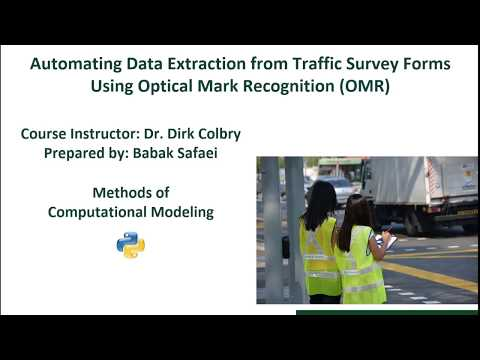

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("WG4IboEoP6U",width=640,height=360)

First, the required packages are imported.

In [2]:
from omr_extracter import omr_extract
import pandas as pd
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
sns.set() 

C:\Users\landa\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The required constants are also defined

In [3]:
# mapping rows of sections and answers in form
MAP = {'driver_visibility': range(1, 3), 'vehicle_type': range(4, 9),
       'driver_phone_use': range(10, 13),
       'driver_seatbelt': range(14, 16), 'driver_age': range(17, 20),
       'brake_lights': range(21, 23),
       'passenger_location': range(24, 26), 'lane': range(27, 30),
       'passenger_seatbelt': range(31, 33)}

NUM_RW, NUM_CL = 33, 7  # number of rows and columns in the form
UP = 0  # top margin info of the form for cutting
DOWN = 0  # down margin info of the form for cutting
RIGHT = 70  # right margin info of the form for cutting
LEFT = 70  # left margin info of the form for cutting
TOPX, TOPY = 496, 79  # starting point of grids in top and left of form
STEPX, STEPY = 267, 77  # step size for answer boxes

In the following cell, a sample image from the filled form is loaded and shown for a better understanding of the project.

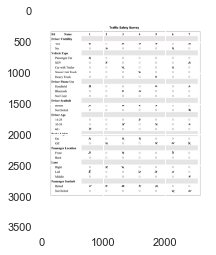

In [4]:
example_form= omr_extract.show_img('images/three/scan3.jpg')

In the following cell, the available image in the `./images/three` folder are read and stored in a list named `files`.

In [5]:
files = omr_extract.get_files('images/three')
print(files)

['images/three\\scan3.jpg']


The available images in the `files` list are read in grayscale mode and stored in an array. You may see the array below.

In [6]:
images = omr_extract.imgs_load(files)
images

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

The first image is shown below.

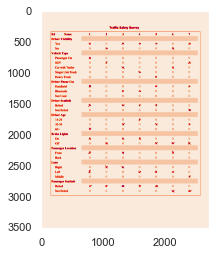

In [7]:
omr_extract.draw_img(images[0])
plt.grid()

The image is cropped to include the required part and is represented below.

In [8]:
cropped_image = images[0][UP:images[0].shape[0] -
                          DOWN, LEFT:images[0].shape[1] - RIGHT]

In [9]:
cropped_image.shape

(3520, 2580)

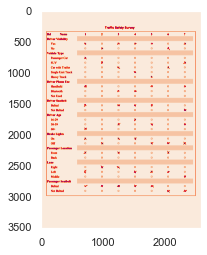

In [10]:
omr_extract.draw_img(cropped_image)
plt.grid()

Now, the image will be cropped and preprocessed using guassianbluring, canny edge detection and contrast improvement.

In [11]:
pre_processed_image = omr_extract.pre_process(cropped_image)

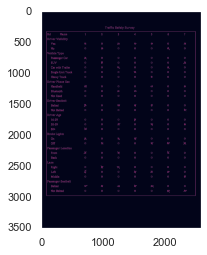

In [12]:
omr_extract.draw_img(pre_processed_image)
plt.grid()

When a document gets scanned, there is great chance that the provided view is not straight enough or the view is not top-down like a bird-eye view. For example, the building construction drawings and maps provide the same view and perspective. Therefore the countours of the image are extracted and a method of perspective transformation is run to get this bird eye view and contours of our document. Contours are lines that connect the points with similar pixel intensity values together. Here the biggest contour is the big black box surrounding the question paper. By getting that we omit the parts of the image that are outside the box and change the view of the image to a top-down format.

In [13]:
image, cont = omr_extract.bird_eye(images[0])

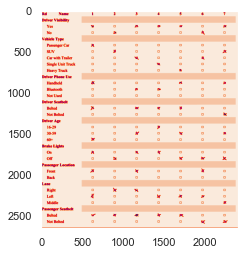

In [14]:
omr_extract.draw_img(image)
plt.grid()

Also, the following cell provides a view of the contours that I mentioned above. Those black areas are removed from the first image that we had.

In [15]:
cont_img = cv2.drawContours(omr_extract.bin_blk(image), cont, -1, 255, -1)

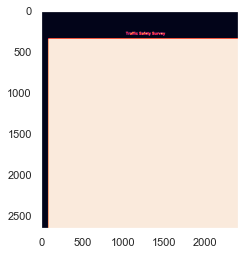

In [16]:
omr_extract.draw_img(cont_img)
plt.grid()

Now that we have the bird-eye view of the document and have removed the outer box, we again improve the contrast and move forward to identify the answer boxes.

In [17]:
image = cv2.addWeighted(image.copy(), 1.5, omr_extract.bin_wht(image), 0, 0)

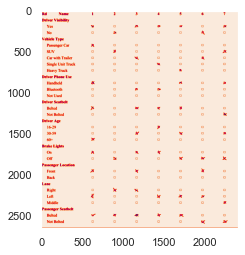

In [18]:
omr_extract.draw_img(image)
plt.grid()

Now for identifying the cells filled with answers, I am going to create a 2d array, named pandora, with the size equivalent to the number of answer boxes in the image. Then, the relative darkness of the answer boxes are going to be recorded in the mentioned pandora array, from which we can identify which answer boxes are filled. 
I have named it pandora because its the key for finding answers, and when it opens the results come out.

In [19]:
pandora = np.zeros((NUM_RW, NUM_CL), dtype=np.float32)

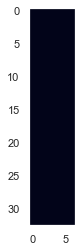

In [20]:
omr_extract.draw_img(pandora)
plt.grid()

In [21]:
for i in range(NUM_RW):
    for j in range(NUM_CL):
#record the relative darkness of answer boxes in pandora array
        x = np.sum(omr_extract.find_cellbox(image, i, j)) / (255 * STEPX * STEPY)
        pandora[i, j] = 1-x

The picture below shows the pandora array after the relative darkness of the cells have been recorded in it.

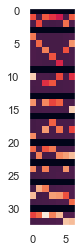

In [22]:
omr_extract.draw_img(pandora)
plt.grid()

According to the relative darkness above, the answer boxes that are filled are extracted and recorded below in a dictionary named answers. The keys of this dictionary are the question section names and the values of this dictionary are the actual  indexes of the boxes filled.

In [23]:
answers = omr_extract.answer_omr(pandora)

Explanation of data:
    
- __Driver Visibility__ : 1 = Visible, 2 = not visisble
- __Vehicle Type__: 1 = Passenger Car, 2 = SUV, 3 = Car with Trailer, 4 = Single Unit Truck, 5 = Heavy Truck
- __Driver Phone Use__: 1 = Handheld, 2 = Bluetooth, 3 = Not Used
- __Driver Seatbelt__: 1 = Belted, 2 = Not Belted
- __Driver Age__: 1 = 16-29, 2 = 30-59, 3 = Over 60 years old
- __Brake Lights__: 1 = On, 2 = Off
- __Passenger Location__: 1 = Front, 2 = Back
- __Lane__: 1 = Right, 2 = Left, 3 = Middle
- __Passenger Seatbelt__: 1 = Belted, 2 = Not Belted

In [24]:
answers

{'driver_visibility': [1, 2, 1, 1, 1, 2, 1],
 'vehicle_type': [1, 2, 3, 4, 5, 3, 2],
 'driver_phone_use': [1, 0, 2, 2, 1, 0, 1],
 'driver_seatbelt': [1, 0, 1, 1, 1, 0, 2],
 'driver_age': [3, 0, 2, 1, 2, 0, 2],
 'brake_lights': [1, 2, 1, 1, 2, 2, 2],
 'passenger_location': [1, 0, 1, 0, 0, 1, 0],
 'lane': [2, 1, 1, 2, 2, 2, 3],
 'passenger_seatbelt': [1, 1, 1, 1, 1, 2, 2]}

Now, the extracted answers are exported to a pandas dataframe.

In [25]:
data=omr_extract.run_omr('images/three')[0]

In [26]:
data.head()

Number  Driver Visible  Type  Driver Phone Use  Driver Seatbelt  \
0       1               1     1                 1                1   
1       2               2     2                 0                0   
2       3               1     3                 2                1   
3       4               1     4                 2                1   
4       5               1     5                 1                1   

   Driver Age  Brake Lights  Passenger Loc  Lane  Passenger Seatbelt  
0           3             1              1     2                   1  
1           0             2              0     1                   1  
2           2             1              1     1                   1  
3           1             1              0     2                   1  
4           2             2              0     2                   1

Below, you may review the summary of the data. This survey form was filled just as a sample by me and the data is not representing real world results.

In [27]:
data.describe()

Number  Driver Visible      Type  Driver Phone Use  Driver Seatbelt  \
count  7.000000        7.000000  7.000000          7.000000         7.000000   
mean   4.000000        1.285714  2.857143          1.000000         0.857143   
std    2.160247        0.487950  1.345185          0.816497         0.690066   
min    1.000000        1.000000  1.000000          0.000000         0.000000   
25%    2.500000        1.000000  2.000000          0.500000         0.500000   
50%    4.000000        1.000000  3.000000          1.000000         1.000000   
75%    5.500000        1.500000  3.500000          1.500000         1.000000   
max    7.000000        2.000000  5.000000          2.000000         2.000000   

       Driver Age  Brake Lights  Passenger Loc      Lane  Passenger Seatbelt  
count    7.000000      7.000000       7.000000  7.000000            7.000000  
mean     1.428571      1.571429       0.428571  1.857143            1.285714  
std      1.133893      0.534522       0.534522  0.690066            0.487950  
min      0.000000      1.000000       0.000000  1.000000            1.000000  
25%      0.500000      1.000000       0.000000  1.500000            1.000000  
50%      2.000000      2.000000       0.000000  2.000000            1.000000  
75%      2.000000      2.000000       1.000000  2.000000            1.500000  
max      3.000000      2.000000       1.000000  3.000000            2.000000

Also, eight plots are driven below to show the relationship between the data. For instance, a histogram of driver ages is provided, the driver age and cell phone usage are plotted against eachother. Such plots and the final data can be used in transportation research studies related to traffic safety and driver behavior analysis.

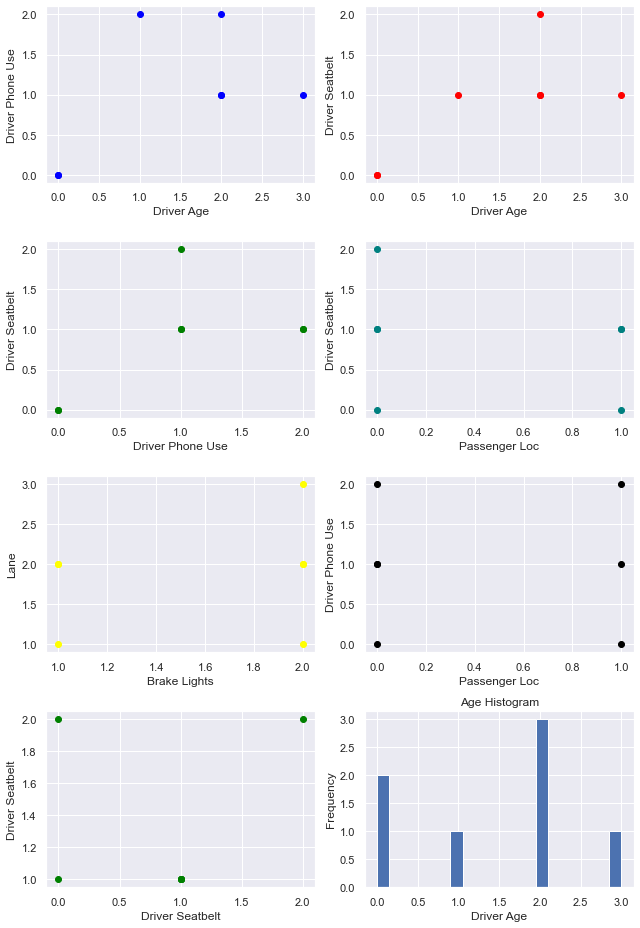

In [28]:
plt.figure(figsize=(9,13))
plt.subplot(421)
omr_extract.plot_data(data["Driver Age"], data["Driver Phone Use"], "Driver Age", "Driver Phone Use")
plt.subplot(422)
omr_extract.plot_data(data["Driver Age"], data["Driver Seatbelt"], "Driver Age", "Driver Seatbelt", "red")
plt.subplot(423)
omr_extract.plot_data(data["Driver Phone Use"], data["Driver Seatbelt"], "Driver Phone Use", "Driver Seatbelt", "green")
plt.subplot(424)
omr_extract.plot_data(data["Passenger Loc"], data["Driver Seatbelt"], "Passenger Loc", "Driver Seatbelt", "teal")
plt.subplot(425)
omr_extract.plot_data(data["Brake Lights"], data["Lane"], "Brake Lights", "Lane", "yellow")
plt.subplot(426)
omr_extract.plot_data(data["Passenger Loc"], data["Driver Phone Use"], "Passenger Loc", "Driver Phone Use", "black")
plt.subplot(427)
omr_extract.plot_data(data["Driver Seatbelt"], data["Passenger Seatbelt"], "Driver Seatbelt", "Driver Seatbelt", "green")
plt.subplot(428)
plt.hist(data["Driver Age"], bins=20)
plt.xlabel("Driver Age")
plt.ylabel("Frequency")
plt.title("Age Histogram")
plt.tight_layout()